## Import modules/scripts and optimize portfolio weights:

In [7]:
from datetime import date, timedelta
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import numpy as np
import torch

from JSONReader import read_json
from cov_matrix import MPTCovMat
from allocator import WeightOptimizer
from backtesting import BackTester

### Set desired parameters

In [8]:
# ---------- OPTIMIZATION ----------
train_start = date(2022,1,1)
train_end = date(2023,12,31)

#loss function:
alpha = 0.3 #calmar
beta = 0.1 #omega
gamma = 0.6 #sortino

#target:
rf = 0.027 #risk free rate (can be used as target rate instead)
rf_period = timedelta(120) #number of days for risk free, e.g. 365 for annual 

num_iter = 10000 #number of weight update iterations
weight_decay = 0.1 #affects distribution of weights - higher value will lead to more even distribution

# ---------- COMPARISON ---------- 
test_start=date(2024,1,1)
test_end=date(2024,12,31 )
comparison_ticker = '^OMX' #ticker of index to compare against


### Optimize weights

In [9]:
ticker_list = read_json('assets.json')
tickers = yf.Tickers(ticker_list)

#get data
data = MPTCovMat(tickers=tickers,start=train_start,end=train_end)
returns = data.log_return_df
col_indices = data.col_indices
asset_names = [col_indices[i] for i in sorted(col_indices.keys())]

allocator = WeightOptimizer(lr=1e-3,num_assets=len(asset_names),risk_free=rf,risk_free_period=rf_period,num_iter=num_iter, weight_decay=weight_decay)
cos_losses, pf_daily_returns = allocator.optimize_weights(alpha,beta,gamma, returns=torch.tensor(returns.values))
weights = pd.DataFrame(allocator.alloc_weights.numpy(force=True), index=asset_names, columns=['Weights'])
weights.index.name = 'Ticker'
weights['Weights %'] = weights['Weights']*100
weights['Weights %'].to_csv('weights.csv')
print(weights['Weights %'])

[*********************100%***********************]  30 of 30 completed


Optimizing weights... 
Ticker
ABB.ST          6.069823
ALFA.ST         3.338639
ASSA-B.ST       2.221748
ATCO-A.ST       3.594273
ATCO-B.ST       1.356684
AZN.ST          2.374762
BOL.ST          1.067518
ELUX-B.ST       0.399257
ERIC-B.ST       0.705999
ESSITY-B.ST     0.658029
EVO.ST          1.396468
GETI-B.ST       0.544178
HEXA-B.ST       0.755216
HM-B.ST         3.969703
INVE-B.ST      36.199535
KINV-B.ST       0.087172
NDA-SE.ST       0.187113
NIBE-B.ST       0.422707
SAAB-B.ST      16.678228
SAND.ST         0.184783
SBB-B.ST        0.669648
SCA-B.ST        1.165641
SEB-A.ST        2.073325
SHB-A.ST        2.275167
SINCH.ST        0.973869
SKF-B.ST        1.195029
SWED-A.ST       2.044305
TEL2-B.ST       1.242764
TELIA.ST        1.017604
VOLV-B.ST       5.130806
Name: Weights %, dtype: float32


### Plot sharpe ratios to number of iterations

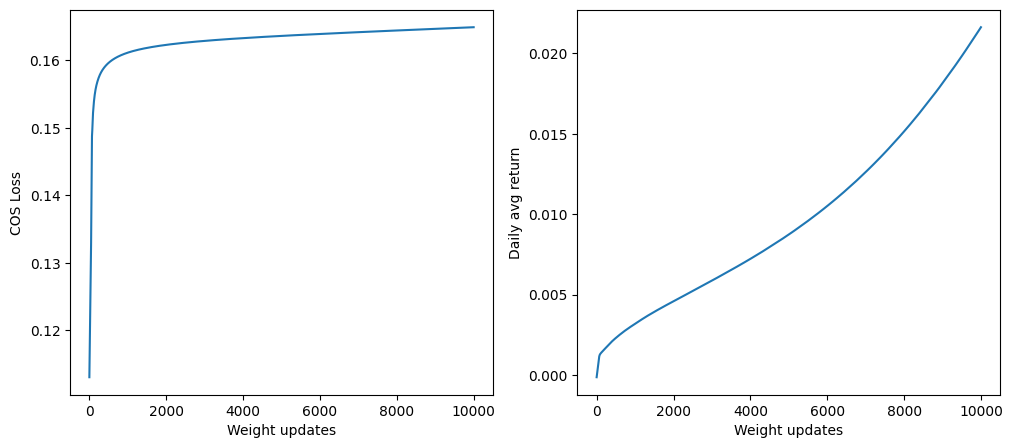

In [10]:
x_df = pd.DataFrame(range(0,num_iter))
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.plot(x_df,cos_losses.numpy(force=True),)
ax1.set_xlabel('Weight updates')
ax1.set_ylabel('COS Loss')
ax2.plot(x_df,pf_daily_returns.numpy(force=True),)
ax2.set_xlabel('Weight updates')
ax2.set_ylabel('Daily avg return')
plt.show()

## Backtesting

### Get comparison data

In [11]:
tester = BackTester(test_weights=pd.DataFrame(weights['Weights']),start=test_start,end=test_end,tickers=tickers)
comp_data = yf.Ticker(comparison_ticker).history(start=test_start,end=test_end,auto_adjust=True)
comp_returns:pd.DataFrame = comp_data['Close'].pct_change()
comp_returns.dropna(inplace=True)
comp_cumulative = np.exp(comp_returns.cumsum()) - 1

[*********************100%***********************]  30 of 30 completed


TESTING


### Plot  results

Comparison portfolio return: 4.49 %
Optimized portfolio return: 24.7 %
Percentage point difference: 20.21 pp
Percentage difference: 450.11 %


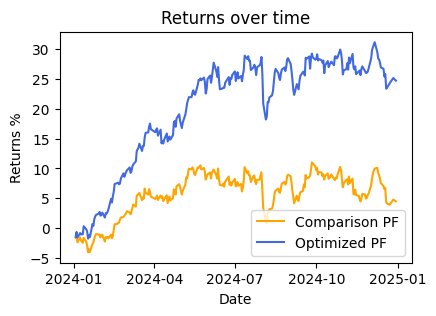

In [12]:
comp_returns = pd.DataFrame(comp_cumulative)
test_returns = tester.cumulative_returns(tester.test_portfolio_returns)
ax1=plt.subplot(1,2,1)
ax1.set_title('Returns over time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Returns %')
ax1.figure.set_size_inches(10,3)
ax1.xaxis.set_major_formatter(mdates.AutoDateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=2,maxticks=6))
ax1.plot(comp_returns.mul(100),color='orange')
ax1.plot(test_returns.mul(100),color='royalblue')
ax1.legend(['Comparison PF','Optimized PF'])
comp_final_return = round((comp_returns.iloc[-1].values*100).item(),2)
optimized_final_return = round((test_returns.iloc[-1,:].values*100).item(),2)
comp_optim_diff = optimized_final_return-comp_final_return
perc_diff = round(((optimized_final_return/comp_final_return)-1)*100,2)

print(f'Comparison portfolio return: {str(comp_final_return)+' %'}')
print(f'Optimized portfolio return: {str(optimized_final_return)+' %'}')
print(f'Percentage point difference: {round(comp_optim_diff,2)} pp')
print(f'Percentage difference: {round(((optimized_final_return/comp_final_return)-1)*100,2)} %')